Author: Shawn Whitfield <br>
Version: 1 <br>
Date: 2022-10-07 <br> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in data and assign X and y
data = pd.read_csv('fe_train_data.csv', index_col=0)
y = data['isGoal']
X = data.drop(columns = 'isGoal')

Using training dataset, create a training and validation split

In [3]:
from sklearn.model_selection import train_test_split
# Standard 80:20 split train:validation
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Using only the distance feature, train a Logistic Regression classifier with the completely default settings

In [4]:
# Select only the distance feature and format it for the classifier
X_train_d = X_train['distanceFromNet'].to_numpy().reshape(-1,1)
X_val_d = X_val['distanceFromNet'].to_numpy().reshape(-1,1)

In [5]:
# Train the classifier and get predictions
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(X_train_d,y_train)
clf_preds = clf.predict(X_val_d)
score = clf.score(X_val_d,y_val)
print(f'accuracy score: {score}')

accuracy score: 0.9041387332782319


In [6]:
# Look at where it's all gone wrong
X_val_compar = X_val.copy()
X_val_compar['preds'] = clf_preds
X_val_compar['actual'] = y_val
wrong_preds = X_val_compar[X_val_compar['preds'] != y_val]
wrong_preds

,gameID,distanceFromNet,angleFromNet,emptyNet,preds,actual
295667,2015020789,167.7647,-5.4727,0,0,1
304138,2015030232,21.0950,-58.5704,0,0,1
119654,2017021261,19.2354,62.1027,0,0,1
68760,2015030241,30.8869,29.0546,0,0,1
67653,2018021108,38.2099,-96.0090,0,0,1
...,...,...,...,...,...,...
353324,2018020184,34.2053,-37.8750,0,0,1
247772,2017020937,19.0000,0.0000,0,0,1
22902,2017021178,10.7703,21.8014,0,0,1
423007,2018020609,12.3693,14.0362,0,0,1


In [7]:
wrong_preds.describe()

,gameID,distanceFromNet,angleFromNet,emptyNet,preds,actual
count,6.263000e+03,6263.000000,6263.000000,6263.000000,6263.0,6263.0
mean,2.016568e+09,30.160260,-0.342860,0.049497,0.0,1.0
std,1.122200e+06,34.326019,32.946473,0.216921,0.0,0.0
min,2.015020e+09,1.414200,-126.869900,0.000000,0.0,1.0
25%,2.016020e+09,11.000000,-23.198600,0.000000,0.0,1.0
50%,2.017020e+09,19.105000,0.000000,0.000000,0.0,1.0
75%,2.018020e+09,34.058800,21.801400,0.000000,0.0,1.0
max,2.018030e+09,187.181700,180.000000,1.000000,0.0,1.0


The model systematically underestimates goals ie. it fails to predict goals. <br>
All of the actual are 1 while all the predicted are 0.

In [8]:
# Get probabilities associated with each class, for each point in X_val_d
probs_d = clf.predict_proba(X_val_d)

In [9]:
def plot_ROC(y_val,probs,title = False, savename=False):
    """
    Plots an ROC curve for the given y (ground truth) and model probabilities, and calculates the AUC.
    """
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_val,probs)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    #Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title}")
    plt.legend(loc="lower right")

    plt.tight_layout()
    if savename:
        plt.savefig(f'{savename}.png')
    plt.show()
    plt.clf()

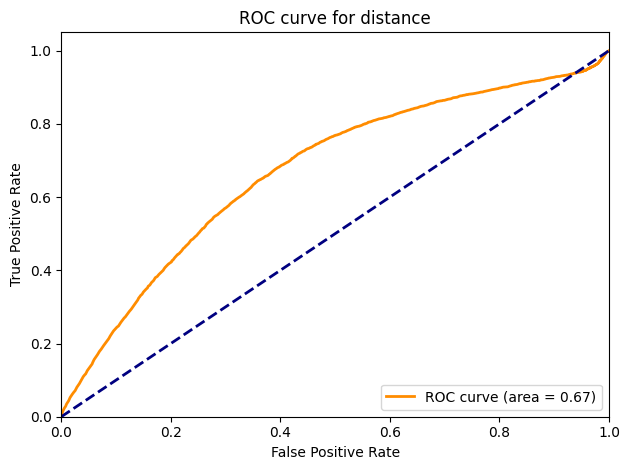

<Figure size 640x480 with 0 Axes>

In [10]:
plot_ROC(y_val, probs_d[:,1], 'ROC curve for distance')

In [ ]:
# The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability 
#     model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data.

In [ ]:
# The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

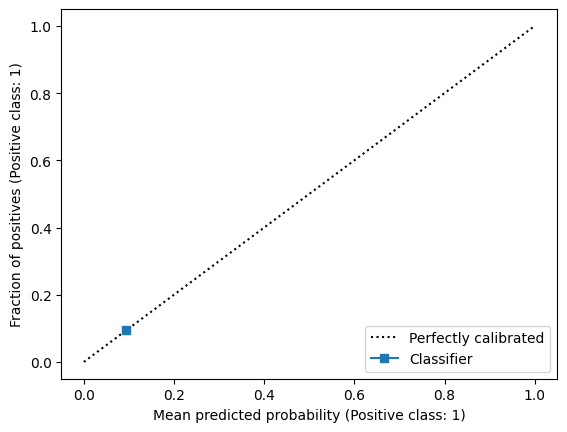

In [11]:
# The reliability diagram (calibration curve). Scikit-learn provides functionality to create 
# a reliability diagram in a few lines of code; check out the CalibrationDisplay API 
# (specifically the .from_estimator() or .from_predictions() methods) for more information.
from sklearn.calibration import calibration_curve, CalibrationDisplay
